# WISE COMPUTING HEAVENS: Graviational Waves and Noise Filtering
Instructor: Ian Johnson

Date: March 10 2025

Today we will expand on the FFT lessons from last class. We will learn how to work with real data and deal with noise.

In [83]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram

# Loading Data
This is one of many ways to load data into python. Make sure to read your files as best you can before trying to code with them!

I have several files prepped for you, but we will handle these one at a time.

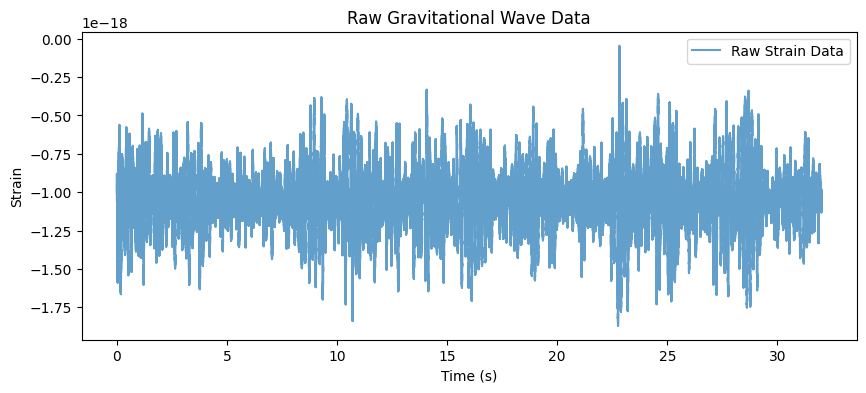

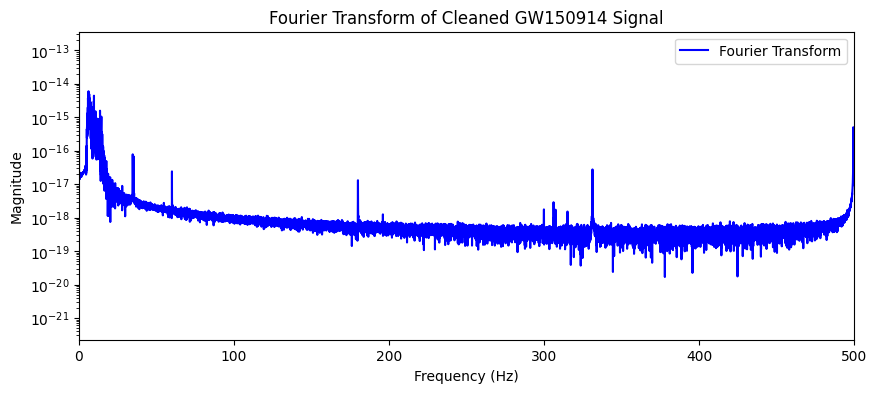

In [ ]:
# Load data
data = np.loadtxt("H-H1_GWOSC_4KHZ_R1-1126259447-32.txt")
# data = np.loadtxt("L-L1_GWOSC_4KHZ_R1-1126259447-32.txt")
# data = np.loadtxt("H-H1_GWOSC_16KHZ_R1-1126259447-32.txt")

# Define time array
fs = 4096  # Sampling rate in Hz
# fs = 16384 # Sampling for higher resolution data
duration = 32  # Seconds
t = np.linspace(0, duration, len(data), endpoint=False)

# Plot raw data
plt.figure(figsize=(10, 4))
plt.plot(t, data, label="Raw Strain Data", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Raw Gravitational Wave Data")
plt.legend()
plt.show()

# Compute FFT of the cleaned signal
N = len(data)
fft_vals = np.fft.rfft(data)  # Compute real FFT
freqs = np.fft.rfftfreq(N, 1/fs)  # Frequency axis

# Plot power spectrum
plt.figure(figsize=(10, 4))
plt.plot(freqs, np.abs(fft_vals), color="blue", label="Fourier Transform")
plt.xlim(0, 500)  # Focus on relevant GW frequency range
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
# plt.ylim([0, np.max(fft_vals)])
plt.yscale('log')
plt.title("Fourier Transform of Cleaned GW150914 Signal")
plt.legend()
plt.show()


# Cutting Loose Ends

Sometimes we only want some of the data. Here, we cut just the first and last second off for now.

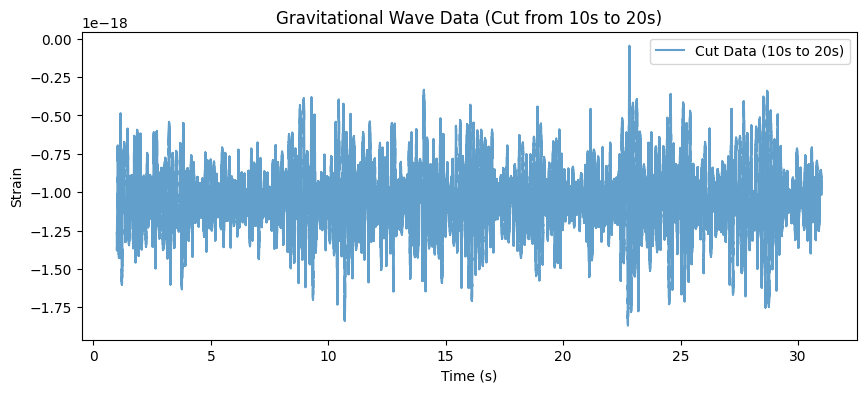

In [85]:

# Cut the data around the merger 
start_time = 1
end_time = 31 

# Find the indices corresponding to the time range
start_idx = int(start_time * fs)
end_idx = int(end_time * fs)

# Slice the data and time array to the desired range
data_cut = data[start_idx:end_idx]
t_cut = t[start_idx:end_idx]

# Plot the sliced data
plt.figure(figsize=(10, 4))
plt.plot(t_cut, data_cut, label="Cut Data (10s to 20s)", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Gravitational Wave Data (Cut from 10s to 20s)")
plt.legend()
plt.show()


# Filters

No, these filters are not for photos, but they do smooth out some real-world imperfections.

Below I have a high-pass filter which only lets high frequencies pass through (cutout lowend). In the music world, this would be like cutting out the bass.

There are also, lowpass (cut high freqencies) and bandpass (select a range of frequencies). We will be using the more general latter case.

In [86]:
# High-pass filter (removes noise below 20 Hz)
def butter_highpass_filter(data, cutoff=20, fs=4096, order=4):
    nyquist = 0.5 * fs
    low = cutoff / nyquist
    b, a = butter(order, low, btype="high")
    return filtfilt(b, a, data)


Now we make the filter that we will use for our project!

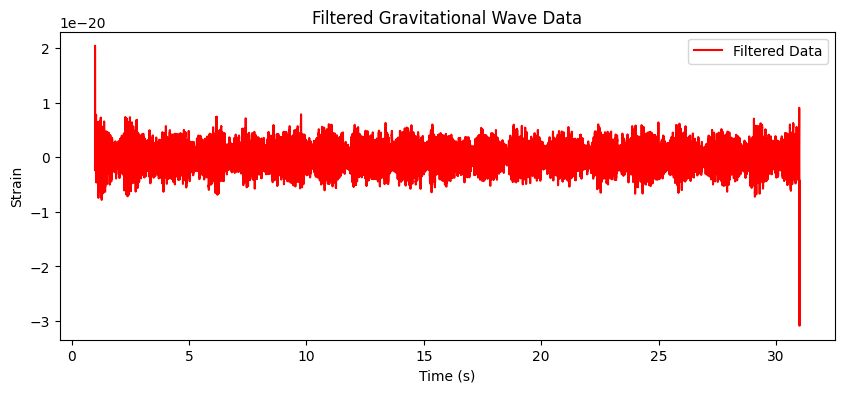

In [87]:
# Bandpass filter (20–300 Hz)
def butter_bandpass_filter(data, lowcut=20, highcut=300, fs=4096, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data)


# Apply filter
filtered_data = butter_bandpass_filter(data_cut, fs=fs)


# Plot filtered data
plt.figure(figsize=(10, 4))
plt.plot(t_cut, filtered_data, label="Filtered Data", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Filtered Gravitational Wave Data")
plt.legend()
plt.show()

Now show the cleaned FFT signal which should looks similar

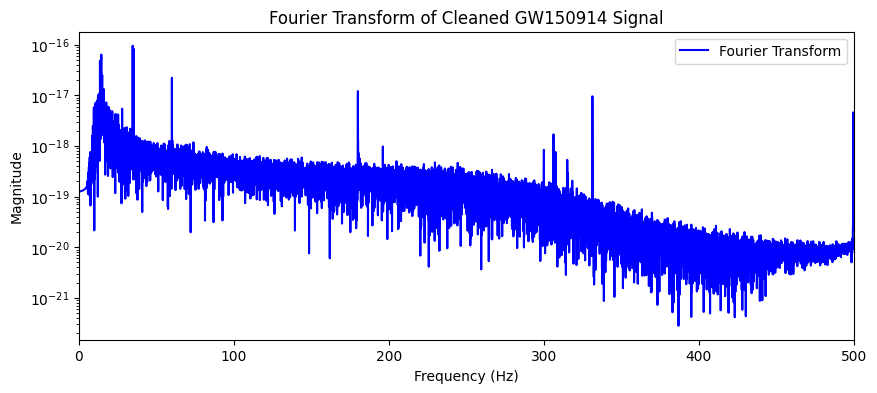

In [88]:
# Compute FFT of the cleaned signal
N = len(filtered_data)
fft_vals = np.fft.rfft(filtered_data)  # Compute real FFT
freqs = np.fft.rfftfreq(N, 1/fs)  # Frequency axis

# Plot power spectrum
plt.figure(figsize=(10, 4))
plt.plot(freqs, np.abs(fft_vals), color="blue", label="Fourier Transform")
plt.xlim(0, 500)  # Focus on relevant GW frequency range
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
# plt.ylim([0, np.max(np.abs(fft_vals))])
plt.yscale('log')
plt.title("Fourier Transform of Cleaned GW150914 Signal")
plt.legend()
plt.show()

# Power Spectral Density (PSD)

Finally we can plot frequency, time, and power simulaneously. The code is a bit more complex, but don't worry too much about the specifics for now.

In [89]:
# Compute the spectrogram for 2D color plot
offset_filtered_data = filtered_data - np.mean(filtered_data)

nperseg_spec = fs//8  # Window size for spectrogram
f_spec, t_spec, Sxx = spectrogram(offset_filtered_data, fs, nperseg=nperseg_spec, noverlap=nperseg_spec//2)

Sxx_normalized = Sxx/np.max(Sxx)

# Convert to log scale for better visualization
Sxx_log = np.log10(Sxx)

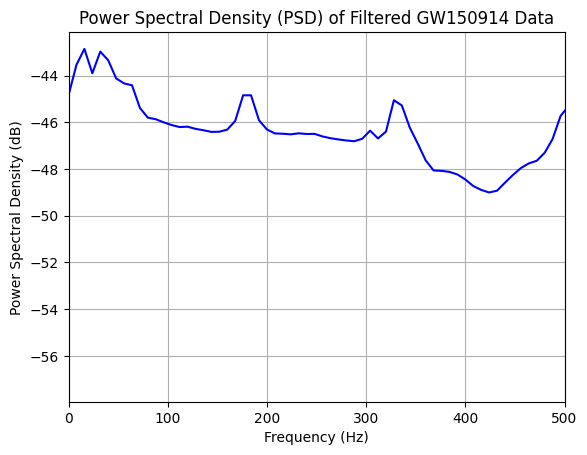

In [90]:
# Plot the PSD
plt.plot(f_spec, np.mean(Sxx_log, axis=1), color='blue')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.title("Power Spectral Density (PSD) of Filtered GW150914 Data")
plt.xlim(0, 500)  # Focus on relevant GW range
# plt.ylim(np.min(Pxx_log), np.max(Pxx_log))
plt.grid(True)
plt.show()

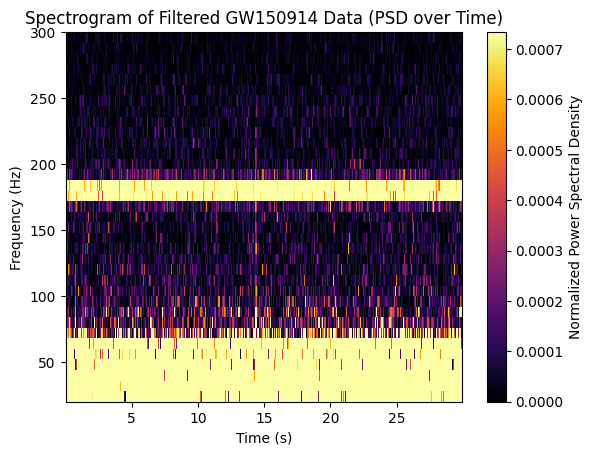

In [94]:
# Adjust color limits for better contrast
vmin, vmax = np.percentile(Sxx_normalized, [5, 95]) # if all same color change to [1, 99]

# Plot the 2D colorized PSD (Spectrogram)
plt.pcolormesh(t_spec, f_spec, Sxx_normalized, shading="auto", cmap="inferno", vmin=vmin, vmax=vmax)
plt.colorbar(label="Normalized Power Spectral Density")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(20, 300)  # Focus on relevant GW range
plt.title("Spectrogram of Filtered GW150914 Data (PSD over Time)")
plt.show()

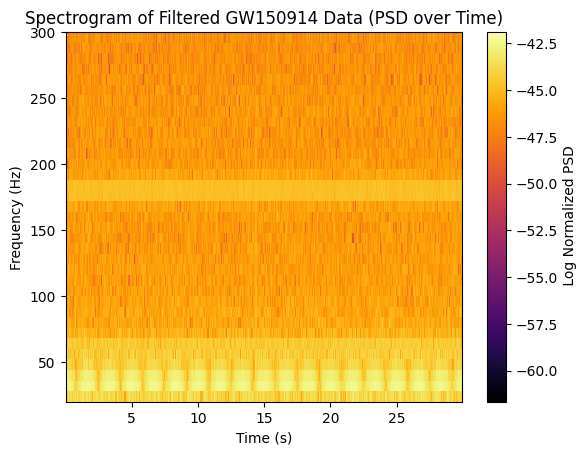

In [92]:
# Adjust color limits for better contrast
vmin, vmax = np.min(Sxx_log), np.max(Sxx_log)

# Plot the 2D colorized PSD (Spectrogram)
plt.pcolormesh(t_spec, f_spec, Sxx_log, shading="auto", cmap="inferno", vmin=vmin, vmax=vmax)
plt.colorbar(label=" Log Normalized PSD")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(20, 300)  # Focus on relevant GW range
plt.title("Spectrogram of Filtered GW150914 Data (PSD over Time)")
plt.show()